## Visualize Router RSSI Data

In [7]:
%matplotlib inline
import sys
sys.path.append('../scripts')
print(sys.path)
import matplotlib.pyplot as plt
import numpy as np
from tools import *
from localizer import *
import json

['', '/home/exx/tensorflow/lib/python3.4', '/home/exx/tensorflow/lib/python3.4/plat-x86_64-linux-gnu', '/home/exx/tensorflow/lib/python3.4/lib-dynload', '/usr/lib/python3.4', '/usr/lib/python3.4/plat-x86_64-linux-gnu', '/home/exx/tensorflow/local/lib/python3.4/site-packages', '/home/exx/tensorflow/local/lib/python3.4/site-packages/gym-0.9.1-py3.4.egg', '/usr/lib/python3/dist-packages', '/home/exx/tensorflow/lib/python3.4/site-packages', '/home/exx/tensorflow/lib/python3.4/site-packages/gym-0.9.1-py3.4.egg', '/usr/local/lib/python3.4/dist-packages', '/usr/local/lib/python3.4/dist-packages/Keras-2.0.5-py3.4.egg', '/home/exx/tensorflow/local/lib/python3.4/site-packages/IPython/extensions', '/home/exx/.ipython', '../scripts', '../scripts', '../scripts', '../scripts']


In [9]:
def split_dataset(X):
    cutoff_train = int(0.8 * len(X))
    cutoff_val = cutoff_train + int(0.1 * len(X))
    return X[:cutoff_train], X[cutoff_train:cutoff_val], X[cutoff_val:]
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize 224 x 224 x 3
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32')
    image /= 255.
    return image
def scale_rssi(rssi):
    return (rssi + 100) * (1./70.)
def scale_mag(mag):
    return (mag + 360.) * (1./720.)
def scale_xy(mapped_values):
    return (mapped_values -10.1) * (1./(59.8-10.1))

In [10]:
hall_loc = localizer()
hall_loc.load_profile('hallway_profile')

def load_data(path, profile=None):
    wifi = []
    mag = []
    img = []
    xy = []
    coordinates = []
    file_count = 0
    if profile is not None:
        for file_name in os.listdir(path):
            if os.path.isfile(path + file_name):
                print('-- loading from {}'.format(file_name))
                file_coords = []
                with open(path + file_name, 'r') as f:
                    data = json.load(f)
                    show = True
                    points = 0
                    print('-- -- Length', len(data['datapoints']))
                    for point in data['datapoints']:
                        points += 1
                        x = float(point['x'])
                        y = float(point['y'])
                        xy.append([x, y])
                        if (x, y) not in file_coords:
                            file_coords.append((x, y))
                        mag.append([point['heading']/360.])
                        img1 = cv2.imread(point['img1'])
                        try:
                            img1 = preprocess_image(img1)
                        except:
                            print(points, point['img1'])
                            return
                        img.append(img1)
                        wifi_row = []
                        for addr in profile:
                            try:
                                wifi_row.append(scale_rssi(float(point['access_points'][addr])))
                            except:
                                wifi_row.append(scale_rssi(-100.0))
                        wifi.append(wifi_row)
                coordinates.append(file_coords)
                print('-- -- Added {} datapoints'.format(points))
                file_count += 1
        print('Loaded {} files from {}'.format(file_count, path))
        xy = scale_xy(np.array(xy))
        return np.array(wifi), np.array(mag), np.float32(img), xy, coordinates
        
wifi, mag, images, y, coordinates = load_data('../datasets/', hall_loc.profile)
print(wifi.shape)

/home/exx/jtf/localizer/Notebooks/network_profiles
Loaded profile: hallway_profile
-- loading from 4th_Floor_NEB-2017-07-26_20_51.json
-- -- Length 840
-- -- Added 840 datapoints
-- loading from 4th_Floor_NEB-2017-07-26_20_29.json
-- -- Length 360
-- -- Added 360 datapoints
-- loading from 4th_Floor_NEB-2017-07-26_19_53.json
-- -- Length 360
-- -- Added 360 datapoints
Loaded 3 files from ../datasets/
(1560, 30)


*Display a graph of wifi signal over time for a given router*

(30, 1560)


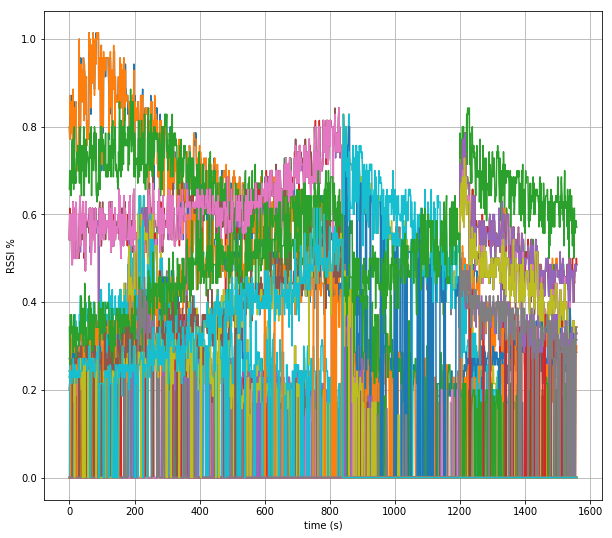

In [11]:
routers = wifi.T
print(routers.shape)
plt.figure(figsize=(10, 9))
for router in routers:
    plt.plot(router)

plt.xlabel('time (s)')
plt.ylabel('RSSI %')
plt.grid(True)
plt.show()

(0,)
[]


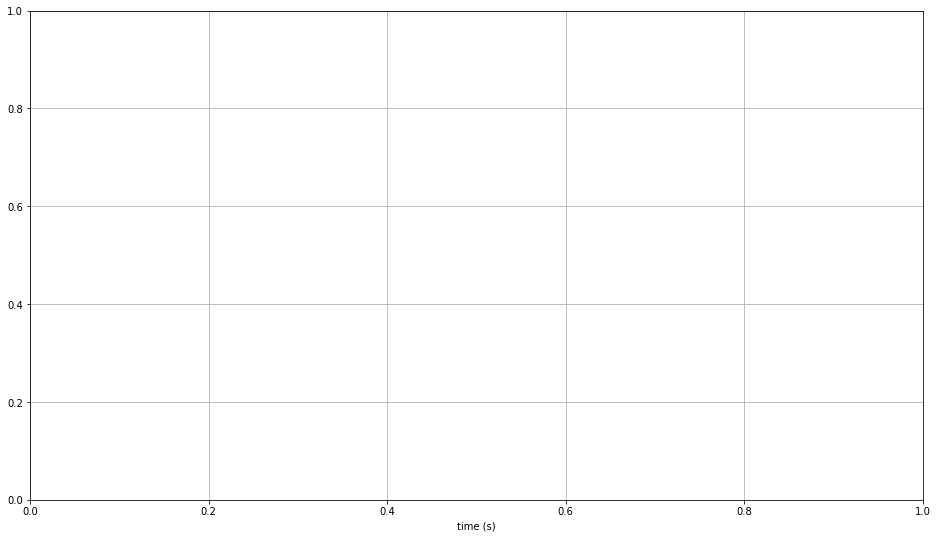

In [5]:
# this is showing the variation at a single point over 4 different sample times (varying t.o.d., angle)
x_pt = []
for i, point in enumerate(y):
    #print(point)
    if str(point) == '[ 0.  1.]':
        x_pt.append(X[i])
for i, point in enumerate(y):
    if str(point) == '[ 0.5  0.5]':
        x_pt.append(X[i])
x_pt = np.array(x_pt)
print(x_pt.shape)

routers2 = x_pt.T
print(routers2)
plt.figure(figsize=(16, 9))
for router in routers2[7:9]:
    plt.plot(router)

plt.xlabel('time (s)')
plt.grid(True)
plt.show()

In [4]:
split = np.array(np.split(routers, 9, axis=1))
split = np.reshape(split, (20, 9, 100))
print(split.shape)

ValueError: array split does not result in an equal division

*Find maximum standard deviation for each router in each location*

In [8]:
stds = np.std(split, axis=2)
print(stds.shape)
print(np.amax(stds))
max_idx = np.unravel_index(np.argmax(stds), stds.shape)
print(stds[max_idx])

(20, 9)
6.59696900099
6.59696900099


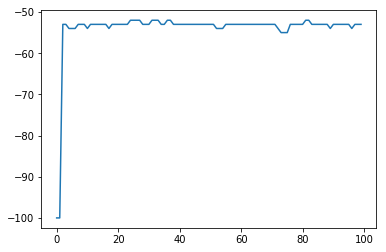

In [9]:
plt.plot(split[max_idx])

## Scaled Data

In [12]:
scaled = scale_inputs(routers)
print(scaled.shape)

(20, 900)


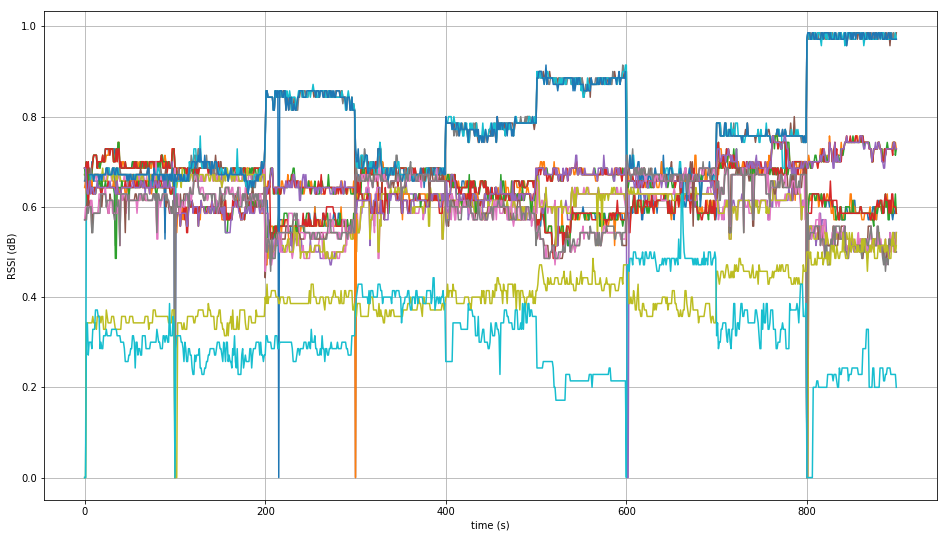

In [15]:
plt.figure(figsize=(16, 9))
for router in scaled:
    plt.plot(router)

plt.xlabel('time (s)')
plt.ylabel('RSSI (dB)')
plt.grid(True)
plt.show()

*Plot average RSSI per location*

In [16]:
scaled_split = scale_inputs(split)
print(scaled_split.shape)
avgs = np.mean(scaled_split, axis=2)
print(avgs.shape)

(20, 9, 100)
(20, 9)


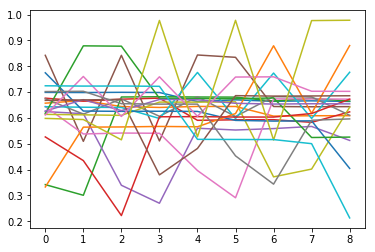

In [24]:
for i, cell in enumerate(avgs):
    plt.plot(cell)
plt.show()